# Extracción y Análisis de Características Textuales
Este notebook implementa un análisis completo de texto utilizando TF-IDF y varios modelos de clasificación.

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from joblib import load
if not os.path.exists("plots/"):
    os.makedirs("plots/")

## Carga y Preparación de Datos
Cargamos las características TF-IDF y etiquetas previamente generadas.

In [2]:
features = load('features/tfidf/features_train.joblib')
labels = load('features/tfidf/labels_train.joblib')

print(f"Dimensiones de las características: {features.shape}")
print(f"Número de clases únicas: {len(np.unique(labels))}")

Dimensiones de las características: (131867, 5000)
Número de clases únicas: 4


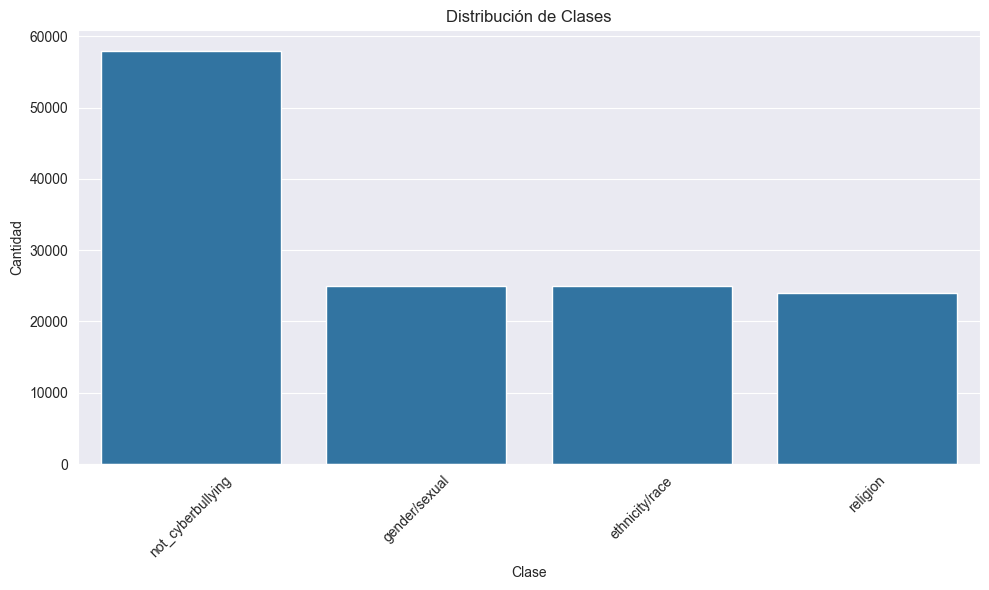

In [3]:
plt.figure(figsize=(10, 6))
clase_counts = pd.Series(labels).value_counts()
sns.barplot(x=clase_counts.index, y=clase_counts.values)
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Cantidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plots/class_distribution.png')

In [4]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

param_grid = {
    'RandomForest': {
        'n_estimators': [20],
        'max_depth': [5, 10],
        'min_samples_split': [2, 5]
    },
    'LogisticRegression': {
        'C': [0.1, 1.0],
        'max_iter': [100]
    },
    'MultinomialNB': {
        'alpha': [0.1, 0.5]
    }
}

models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(random_state=42, solver="saga"),
    'MultinomialNB': MultinomialNB()
}

In [5]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"\nInforme de Clasificación:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusión')
    plt.ylabel('Real')
    plt.xlabel('Predicho')
    plt.savefig(f"plots/confusion_matrix_best_model.png")

    return accuracy_score(y_test, y_pred)

In [ ]:
results = {}
for name, model in models.items():
    print(f"\nEntrenando {name}...")
    grid = GridSearchCV(model, param_grid[name], cv=4, scoring='precision_macro')
    grid.fit(X_train, y_train)
    results[name] = {
        'best_score': grid.best_score_,
        'best_params': grid.best_params_,
        'model': grid.best_estimator_
    }
    print(f"Mejor puntuación: {grid.best_score_:.4f}")
    print(f"Mejores parámetros: {grid.best_params_}")


Entrenando RandomForest...
Mejor puntuación: 0.8848
Mejores parámetros: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 20}

Entrenando LogisticRegression...


In [ ]:
plt.figure(figsize=(10, 6))
scores = [v['best_score'] for v in results.values()]
models_names = list(results.keys())
sns.barplot(x=models_names, y=scores)
plt.title('Comparación de Modelos')
plt.ylabel('Puntuación')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("plots/comparacion_modelos.png")

In [ ]:
best_model_name = max(results, key=lambda k: results[k]['best_score'])
best_model = results[best_model_name]['model']
print(f"\nMejor modelo: {best_model_name}")
final_score = evaluate_model(best_model, X_train, X_test, y_train, y_test)
print(f"\nPuntuación final en conjunto de prueba: {final_score:.4}")

## Predicciones en Nuevos Datos
Realizamos predicciones sobre nuevos datos utilizando el mejor modelo entrenado.

In [ ]:
predict_features = load('features/tfidf/features_predict.joblib')
df_predict = pd.read_csv("BullyingPredict.csv")
predictions = best_model.predict(predict_features)

sample_size = min(10, len(predictions))
random_indices = np.random.choice(len(predictions), size=sample_size, replace=False)
sample_predictions = pd.DataFrame({
    'Texto': df_predict.iloc[random_indices]['text'],
    'Predicción': predictions[random_indices]
})
display(sample_predictions)